# TP1_AD_2021_2022_V1

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd 

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import seaborn as sns

import os 
import pathlib 
import time

# Convert dataset to numpy function
from tensorflow.data import Dataset

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.utils import to_categorical
from itertools import cycle
from sklearn.metrics import auc

In [3]:
# Tensorboard Logs
root_logdir = os.path.join(os.curdir, 'tensorboard_logs_CNN_V1_Rafael')

# Sub-diretoria onde ficarão os dados da execução: tem um nome criado a partir da hora de inicio
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)


## Build data path

In [4]:
DATASET_PATH = '.\\..\\dataset\\micro_expressions'
train_dir = os.path.join(DATASET_PATH, 'train')
test_dir = os.path.join(DATASET_PATH, 'test')

print(f'Dataset path = "{DATASET_PATH}"')
print(f'Train dir path = "{train_dir}"')
print(f'Test dir path = "{test_dir}"', end='\n\n')

train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)
search_pattern = '*\*.jpg'

train_image_count = len(list(train_dir.glob(search_pattern)))
test_image_count = len(list(test_dir.glob(search_pattern)))
test_ratio = test_image_count / (train_image_count + test_image_count)

print('train_image_count =', train_image_count)
print('test_image_count =', test_image_count)
print(f'test ratio = {test_ratio:.4f}')

Dataset path = ".\..\dataset\micro_expressions"
Train dir path = ".\..\dataset\micro_expressions\train"
Test dir path = ".\..\dataset\micro_expressions\test"

train_image_count = 6938
test_image_count = 1700
test ratio = 0.1968


## Load and Normalize Data

In [5]:
# Construção e pré-processamento do Dataset a partir das imagens em disco
# Existem 5 pastas para cada uma das classes
# A informação nas pastas não está dividida em conjuntos de treino e validação
# Consultar detalhes na aula anterior e aqui: https://www.tensorflow.org/tutorials/load_data/images

batch_size = 68 # Aumentar para evitar worning durante treino
IMG_HEIGHT = IMG_WIDTH = 80
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
READ_SEED = 42
IMG_COLOR_CHANNELS = 3

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=READ_SEED,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=READ_SEED,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=None,
  seed=READ_SEED,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

class_names = train_ds.class_names

train_ds = train_ds.cache().prefetch(1)
val_ds = val_ds.cache().prefetch(1)
test_ds = test_ds.cache().prefetch(1)

normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 6938 files belonging to 7 classes.
Using 5551 files for training.
Found 6938 files belonging to 7 classes.
Using 1387 files for validation.
Found 1700 files belonging to 7 classes.


# Data to Numpy

In [6]:
# Convert dataset to numpy
def batch_dataset_to_numpy(ds):
    in_data = []
    out_data = []
    for inp, out in ds:
        
        array = inp.numpy()
        for x in array:
            in_data.append(x)
            
        array = out.numpy()
        for x in array:
            out_data.append(x)
    
    return in_data, out_data


X_train, y_train = batch_dataset_to_numpy(train_ds)
X_val, y_val = batch_dataset_to_numpy(val_ds)
X_test, y_test = batch_dataset_to_numpy(test_ds)


## Print metrics and data information

In [7]:
def print_metrics_by_class(array, title=None, is_rate=False):
    i = 0
    print(title)
    
    for k in class_names:
        if is_rate == True:
            print('\t%s -> %.3f%%' %(k, array[i]))
        else:
            print('\t%s -> %.0f' %(k, array[i]))
        
        i = i + 1

def print_confusion_matrix_metrics(cnf_matrix):
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    
    print_metrics_by_class(FP, '\nFalse Positives:\n')
    print_metrics_by_class(FN, '\nFalse Negatives:\n')
    print_metrics_by_class(TP, '\nTrue Positives:\n')
    print_metrics_by_class(TN, '\nTrue Negatives:\n')
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print_metrics_by_class(TPR, '\nTrue Positive Rate:\n', is_rate=True)
    
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    print_metrics_by_class(TNR, '\nTrue Negative Rate:\n', is_rate=True)
    
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    print_metrics_by_class(PPV, '\nPositive Predictive Value:\n')
    
    # Negative predictive value
    NPV = TN/(TN+FN)
    print_metrics_by_class(NPV, '\nNegative Predictive Value:\n')
    
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    print_metrics_by_class(FPR, '\nFalse Positive Rate:\n', is_rate=True)
    
    # False negative rate
    FNR = FN/(TP+FN)
    print_metrics_by_class(FNR, '\nFalse Negative Rate:\n', is_rate=True)
    
    # False discovery rate
    FDR = FP/(TP+FP)
    print_metrics_by_class(FDR, '\nFalse Discovery Rate:\n', is_rate=True)
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print_metrics_by_class(ACC, '\nAccuracy:\n', is_rate=True)
    
    

def plot_confusion_matrix(y_pred, y_test, labels, normalize_m=None, return_m=False):
    
    fig, ax = plt.subplots(figsize=(10,10))
    matrix = confusion_matrix(y_test, tf.argmax(y_pred, axis=-1), normalize=normalize_m)
    
    fmt_m = '2'
    if normalize_m != None:
        fmt_m = '.3f'
        
    sns.heatmap(
        matrix, 
        annot=True, 
        fmt=fmt_m, 
        cmap='Blues',
        cbar=False, 
        xticklabels=class_names, 
        yticklabels=class_names, 
        ax=ax
    );
    
    plt.title('Confusion Matrix', fontsize = 20)
    plt.ylabel('Real Label', fontsize = 15) 
    plt.xlabel('Predicted Label', fontsize = 15) 
    plt.show();
    
    if return_m == True:
        return matrix
    
    
# https://stackoverflow.com/questions/8409095/set-markers-for-individual-points-on-a-line-in-matplotlib
#linestyle='--', marker='o', color='b'
def plot_loss_and_accuracy(history):
    plt.figure(figsize=(15,10))
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, linestyle='-', marker='.', color='b', label="Training loss")
    plt.plot(epochs, val_loss, linestyle='-', marker='.', color='r', label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show();


    plt.clf()
    plt.figure(figsize=(15,10))
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    plt.plot(epochs, acc, linestyle='-', marker='.', color='b', label="Training accuracy")
    plt.plot(epochs, val_acc, linestyle='-', marker='.', color='r', label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
    plt.show();
    
def plot_epoch_duration(history):
    plt.clf()
    plt.figure(figsize=(15,10))
    dur = history.history['epoch_diff_time']
    epochs = range(1, len(dur) + 1)
    plt.plot(epochs, dur, linestyle='-', marker='.', color='r', label = "Epoch duration")
    plt.title("Epoch Duration by Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Duration (seconds)")
    plt.legend()
    plt.grid(True)
    plt.show();
    
    
def print_dataset_class_balance(class_names, y, title=None):
    print(title)
    y_np = np.array(y)
    length = len(y_np)
    
    for i, x  in enumerate(class_names):
        count = len(y_np[y_np == i])
        print(f" {class_names[i]} = {(count/length):.2f} %")
        
    print('\n')
    

# Has to be defined after getting the data (uses global vars)
def prinf_dataset_information():
    # Cardinality (number of batches)
    print('Train Cardinality (number of batches): ', train_ds.cardinality().numpy())
    print('Validation cardinality (number of batches): ', val_ds.cardinality().numpy())
    print('Test cardinality (number of batches): ', test_ds.cardinality().numpy(), end='\n\n')

    print('Class names: ', class_names, end='\n\n')
    
    print('Shape of X_train: ', np.array(X_train).shape)
    print('Shape of y_train: ', np.array(y_train).shape, end='\n\n')
    print('Shape of X_val: ', np.array(X_val).shape)
    print('Shape of y_val: ', np.array(y_val).shape, end='\n\n')
    print('Shape of X_test: ', np.array(X_test).shape)
    print('Shape of y_test: ', np.array(y_test).shape, end='\n\n')
    
    print_dataset_class_balance(class_names, y_train, 'Class Balance - Train Data:\n')
    print_dataset_class_balance(class_names, y_val, 'Class Balance - Validation Data:\n')
    print_dataset_class_balance(class_names, y_test, 'Class Balance - Test Data:\n')

In [8]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

graph_colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'blue', 'grey']

def plot_multiclass_roc_curve(y_test, y_pred, class_names, single_class = None, title = None):
    
    if title == None:
        title = ''
    
    # Binarize the output
    y_b = to_categorical(y_test, num_classes = len(class_names))
    yp = y_pred

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    thresh = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[str(i)], tpr[str(i)], thresh[str(i)] = roc_curve(y_b[:, i], yp[:, i])
        roc_auc[str(i)] = auc(fpr[str(i)], tpr[str(i)])

    lw = 2 # linewidth
    
    # Compute micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'], thresh['micro'] = roc_curve(y_b.ravel(), yp.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[str(i)] for i in range(len(class_names))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[str(i)], tpr[str(i)])
    
    # Finally average it and compute AUC
    mean_tpr /= len(class_names)

    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
    
    # Plot all ROC curves
    plt.figure(figsize=(15,15))
    plt.plot(
        fpr['micro'], 
        tpr['micro'],
        label = 'Micro-Avg (area = {0:0.2f})'.format(roc_auc['micro']),
        color = 'deeppink',
        linestyle = '--', 
        linewidth = lw
    );

    plt.plot(
        fpr['macro'], 
        tpr['macro'],
        label = 'Macro-Avg (area = {0:0.2f})'.format(roc_auc['macro']),
        color = 'navy', 
        linestyle = '--', 
        linewidth = lw
    );

    colors = cycle(graph_colors)
    for i, color in zip(range(len(class_names)), colors):
        if single_class == None:
            plt.plot(
                fpr[str(i)], 
                tpr[str(i)], 
                color = color, 
                lw = lw,
                label = 'ROC - "{0}" (area = {1:0.2f})'.format(class_names[i].capitalize(), roc_auc[str(i)])
            );
        else:
            if single_class == i:
                plt.plot(
                    fpr[str(i)], 
                    tpr[str(i)], 
                    color = color, 
                    lw = lw,
                    label = 'ROC - "{0}" (area = {1:0.2f})'.format(class_names[i].capitalize(), roc_auc[str(i)])
                );
            
    
    plt.plot([0, 1],[0, 1], 'k--', lw = lw, label = 'Random Guessing')
    plt.xlim([-0.025, 1.0])
    plt.ylim([0.0, 1.025])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (TPR vs FPR)' + title)
    plt.legend(loc = 'lower right')
    plt.show()
    
    
    macro_roc_auc_ovo = roc_auc_score(y_b, yp, multi_class="ovo",
                                          average="macro")
    weighted_roc_auc_ovo = roc_auc_score(y_b, yp, multi_class="ovo",
                                             average="weighted")
    
    macro_roc_auc_ovr = roc_auc_score(y_b, yp, multi_class="ovr",
                                          average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_b, yp, multi_class="ovr",
                                             average="weighted")
    
    print("One-vs-One ROC AUC scores:\n\t{:.6f} (macro),\n\t{:.6f} "
              "(weighted by prevalence)"
              .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n\t{:.6f} (macro),\n\t{:.6f} "
              "(weighted by prevalence)"
              .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))


In [9]:
def print_general_metrics(y_pred, y_test):
    pred = tf.argmax(y_pred, axis = -1)
    precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test, pred, average='weighted')
    
    
    print('\nClassification Report:\n')    
    print(classification_report(y_test, pred), end='\n\n')
    
    print('Accuracy: %.3f\n' % accuracy_score(y_test, pred)) 
    print('Balanced accuracy: %.3f\n' % balanced_accuracy_score(y_test, pred))
    print('F1_Score: %.3f\n' % f1_score(y_test, pred, average='weighted'))
    print('Precision: %.3f\n' % precision)    
    print('Recall: %.3f\n' % recall)
    print('ROC AUC (OVR): %.3f\n' % roc_auc_score(y_test, y_pred, multi_class = 'ovr'))
    print('ROC AUC (OVO): %.3f\n\n' % roc_auc_score(y_test, y_pred, multi_class = 'ovo'))
    

In [10]:
prinf_dataset_information()

Train Cardinality (number of batches):  82
Validation cardinality (number of batches):  21
Test cardinality (number of batches):  25

Class names:  ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

Shape of X_train:  (5551, 80, 80, 3)
Shape of y_train:  (5551,)

Shape of X_val:  (1387, 80, 80, 3)
Shape of y_val:  (1387,)

Shape of X_test:  (1700, 80, 80, 3)
Shape of y_test:  (1700,)

Class Balance - Train Data:

 anger = 0.19 %
 disgust = 0.09 %
 fear = 0.06 %
 happiness = 0.25 %
 neutral = 0.08 %
 sadness = 0.19 %
 surprise = 0.14 %


Class Balance - Validation Data:

 anger = 0.18 %
 disgust = 0.08 %
 fear = 0.06 %
 happiness = 0.26 %
 neutral = 0.08 %
 sadness = 0.20 %
 surprise = 0.14 %


Class Balance - Test Data:

 anger = 0.19 %
 disgust = 0.08 %
 fear = 0.06 %
 happiness = 0.25 %
 neutral = 0.08 %
 sadness = 0.19 %
 surprise = 0.14 %




## Print images

In [11]:
def show_first_ten_images():
    plt.figure(figsize=(15,10))
    for images, labels in train_ds.take(1):
        for i in range(10):
            ax = plt.subplot(2, 10, i + 1)
            plt.imshow(images[i].numpy().astype('float32')) 
            plt.title(class_names[labels[i]])
            plt.axis('off')
            
def show_first_16_ways_of_data_augmentation():
    plt.figure(figsize=(15,15))
    for images, _ in train_ds.take(1):
        for i in range(16):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(augmented_images[0].numpy().astype('float32'))
            plt.axis('off')
                   

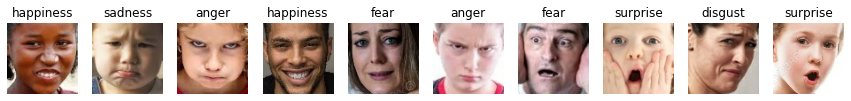

In [12]:
show_first_ten_images()

## Define callbacks

In [13]:
# https://github.com/keras-team/keras/issues/5105
class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.s_time = []
        self.e_time = []
        self.diff_time = []
        
    def on_epoch_begin(self, epoch, logs={}):
        self.s_time.append(time.time())
        
    def on_epoch_end(self, epoch, logs={}):
        now = time.time()
        self.e_time.append(now)
        self.diff_time.append(now - self.s_time[-1])
        
    def on_train_end(self, epoch, logs={}):
        self.model.history.history['epoch_start_time'] = self.s_time
        self.model.history.history['epoch_end_time'] = self.e_time
        self.model.history.history['epoch_diff_time'] = self.diff_time
        

callbacks_l = [
    keras.callbacks.TensorBoard(
        get_run_logdir(), 
        histogram_freq = 1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience = 500, 
        min_delta = 0.005, 
        restore_best_weights = True,
        mode='auto'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = "model_CNN_V1_Rafael",
        monitor = "val_loss",
        save_best_only = True,
        save_weights_only = False
    ),
    TimingCallback()
]


## Define Data Augmentation (sequencial)

In [14]:
# Adicionar Data Augmentation aos exemplos de treino para combater overfitting
# Consultar os links seguintes para obter detalhes: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing
# https://www.tensorflow.org/tutorials/images/data_augmentation


data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_COLOR_CHANNELS)),
    keras.layers.experimental.preprocessing.RandomRotation(0.15),
    keras.layers.experimental.preprocessing.RandomZoom(0.15),
    #keras.layers.experimental.preprocessing.RandomContrast(0.1)
])


a = '''
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_COLOR_CHANNELS)),
    keras.layers.experimental.preprocessing.RandomRotation(0.15),
    keras.layers.experimental.preprocessing.RandomZoom(0.25),
    #keras.layers.experimental.preprocessing.RandomContrast(0.1)
])
'''


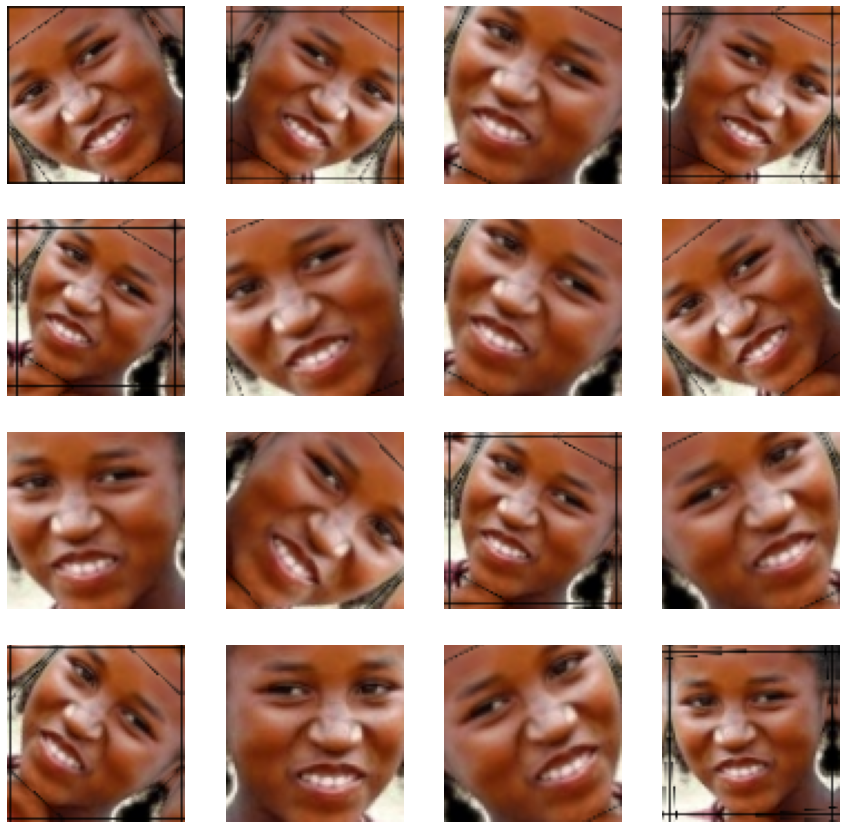

In [15]:
show_first_16_ways_of_data_augmentation()

## Build Model

In [16]:
# Criar modelo com a camada de Data Augmentation - Adicionar como primeira parte do modelo anterior

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# O modelo chama-se model

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_COLOR_CHANNELS))
x = data_augmentation(inputs)
x = keras.layers.Conv2D(filters=40, kernel_size=3, activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Conv2D(70, 3, activation='relu', padding='VALID')(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Conv2D(130, 3, activation='relu', padding='VALID')(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Conv2D(130, 3, activation='relu', padding='VALID')(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(70, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(30, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(7, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

## Plot model

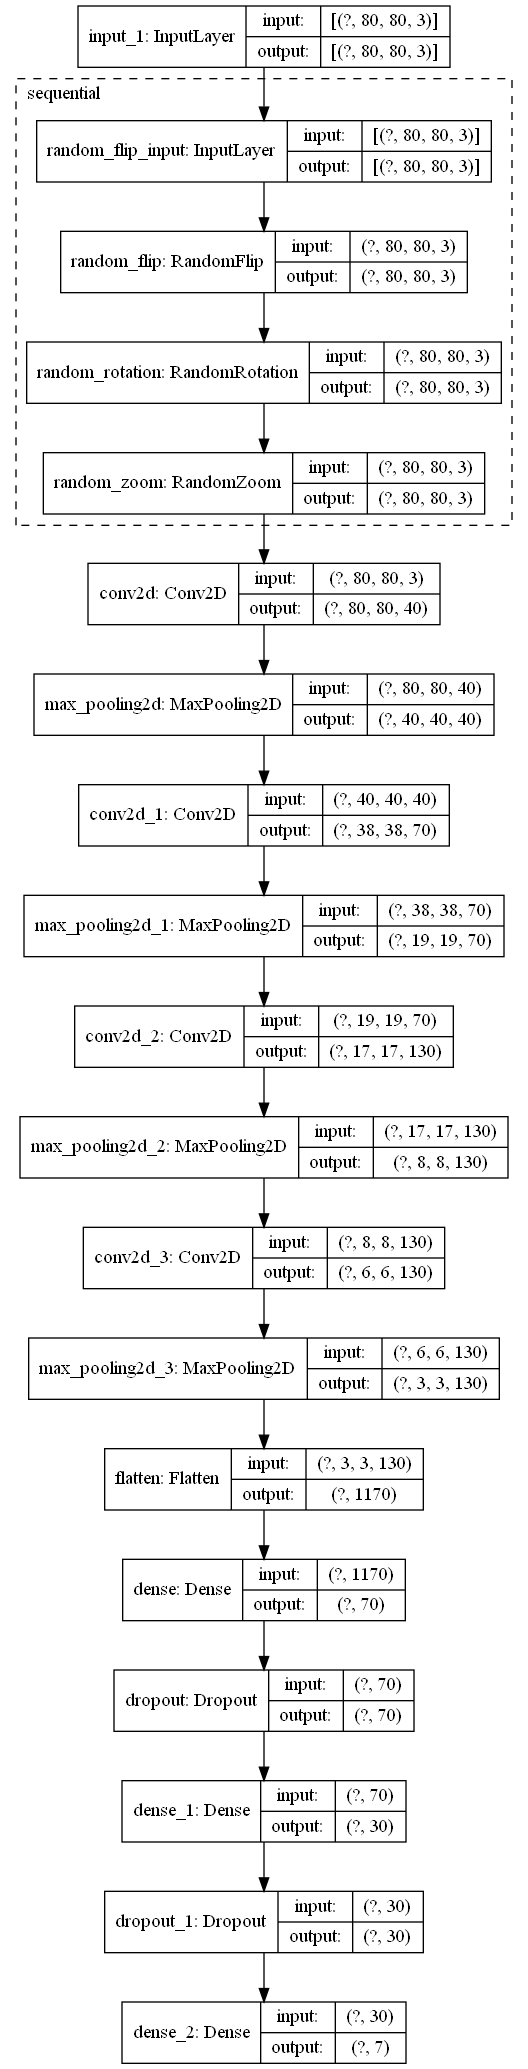

In [17]:
tf.keras.utils.plot_model(
    model,
    to_file="CNN_V1_Rafael.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96
)


In [18]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 80, 80, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 40)        1120      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 38, 70)        25270     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 70)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 130)      

## Compile and train model

In [19]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [20]:
# Compilar e treinar

loss_fn = keras.losses.SparseCategoricalCrossentropy()

metrics_l = [
    'accuracy', # para ter várias métricas é necessário desenvolver a versão multiclass
]

model.compile(
    loss = loss_fn, 
    optimizer = tf.keras.optimizers.Adam(), 
    metrics = metrics_l
)

start_time = time.time()

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 200,
    callbacks = callbacks_l
)

end_time = time.time()
diff_time = end_time - start_time

Epoch 1/200
82/82 [==============================] - 6s 69ms/step - loss: 1.8769 - accuracy: 0.2245 - val_loss: 1.8303 - val_accuracy: 0.2617
Epoch 2/200
82/82 [==============================] - 6s 69ms/step - loss: 1.8291 - accuracy: 0.2610 - val_loss: 1.7357 - val_accuracy: 0.3288
Epoch 3/200
82/82 [==============================] - 7s 80ms/step - loss: 1.7575 - accuracy: 0.3084 - val_loss: 1.6586 - val_accuracy: 0.3742
Epoch 4/200
82/82 [==============================] - 6s 70ms/step - loss: 1.6810 - accuracy: 0.3367 - val_loss: 1.5387 - val_accuracy: 0.4362
Epoch 5/200
82/82 [==============================] - 5s 65ms/step - loss: 1.6221 - accuracy: 0.3689 - val_loss: 1.4793 - val_accuracy: 0.4607
Epoch 6/200
82/82 [==============================] - 6s 73ms/step - loss: 1.5826 - accuracy: 0.3956 - val_loss: 1.4109 - val_accuracy: 0.4831
Epoch 7/200
82/82 [==============================] - 6s 69ms/step - loss: 1.5280 - accuracy: 0.4134 - val_loss: 1.3521 - val_accuracy: 0.4903
Epoch 

82/82 [==============================] - 2s 25ms/step - loss: 0.6960 - accuracy: 0.7600 - val_loss: 0.8084 - val_accuracy: 0.7412
Epoch 116/200
82/82 [==============================] - 2s 25ms/step - loss: 0.6827 - accuracy: 0.7611 - val_loss: 0.8245 - val_accuracy: 0.7354
Epoch 117/200
82/82 [==============================] - 2s 25ms/step - loss: 0.6850 - accuracy: 0.7622 - val_loss: 0.8402 - val_accuracy: 0.7383
Epoch 118/200
82/82 [==============================] - 2s 25ms/step - loss: 0.6946 - accuracy: 0.7629 - val_loss: 0.8010 - val_accuracy: 0.7253
Epoch 119/200
82/82 [==============================] - 2s 25ms/step - loss: 0.6983 - accuracy: 0.7588 - val_loss: 0.7861 - val_accuracy: 0.7469
Epoch 120/200
82/82 [==============================] - 2s 25ms/step - loss: 0.6886 - accuracy: 0.7617 - val_loss: 0.7756 - val_accuracy: 0.7404
Epoch 121/200
82/82 [==============================] - 2s 25ms/step - loss: 0.6637 - accuracy: 0.7698 - val_loss: 0.8401 - val_accuracy: 0.7340
Epoch 

Epoch 172/200
82/82 [==============================] - 2s 25ms/step - loss: 0.5811 - accuracy: 0.7966 - val_loss: 0.8315 - val_accuracy: 0.7462
Epoch 173/200
82/82 [==============================] - 2s 26ms/step - loss: 0.6074 - accuracy: 0.7941 - val_loss: 0.8985 - val_accuracy: 0.7426
Epoch 174/200
82/82 [==============================] - 2s 26ms/step - loss: 0.5996 - accuracy: 0.7917 - val_loss: 0.8166 - val_accuracy: 0.7549
Epoch 175/200
82/82 [==============================] - 2s 26ms/step - loss: 0.5830 - accuracy: 0.8017 - val_loss: 0.8233 - val_accuracy: 0.7513
Epoch 176/200
82/82 [==============================] - 2s 26ms/step - loss: 0.5964 - accuracy: 0.7982 - val_loss: 0.8050 - val_accuracy: 0.7505
Epoch 177/200
82/82 [==============================] - 2s 25ms/step - loss: 0.5727 - accuracy: 0.8044 - val_loss: 0.8804 - val_accuracy: 0.7462
Epoch 178/200
82/82 [==============================] - 2s 25ms/step - loss: 0.5869 - accuracy: 0.7986 - val_loss: 0.8117 - val_accuracy:

## Show model results

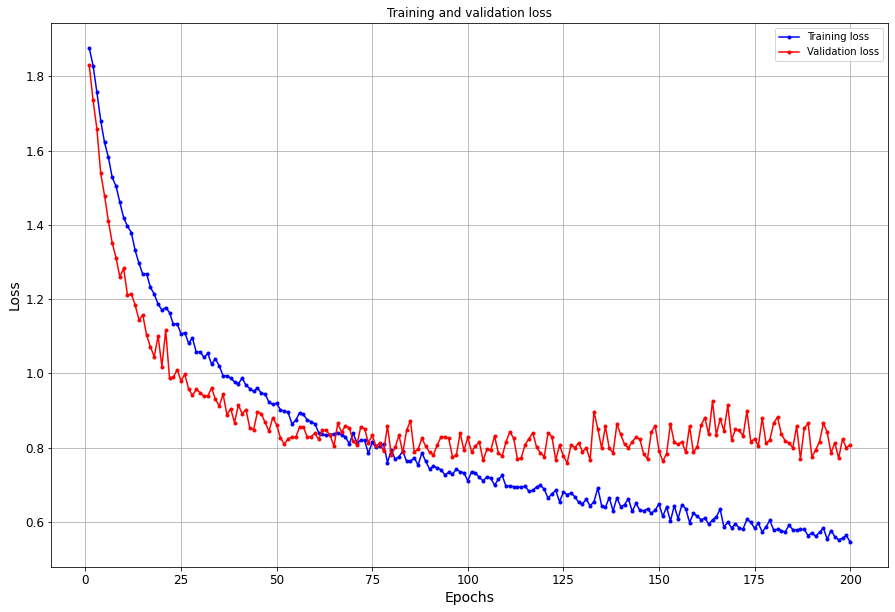

<Figure size 432x288 with 0 Axes>

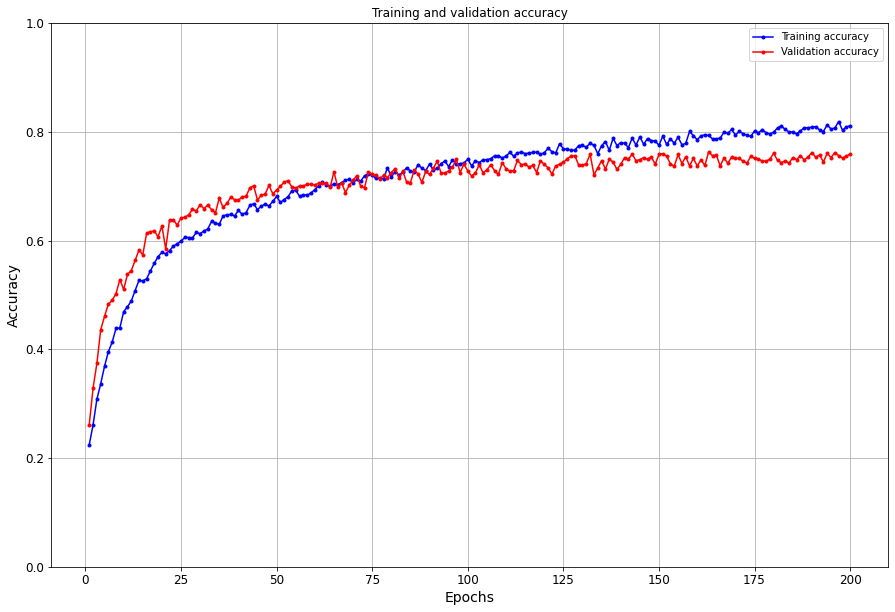

In [21]:
plot_loss_and_accuracy(history)

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'epoch_start_time', 'epoch_end_time', 'epoch_diff_time'])

<Figure size 432x288 with 0 Axes>

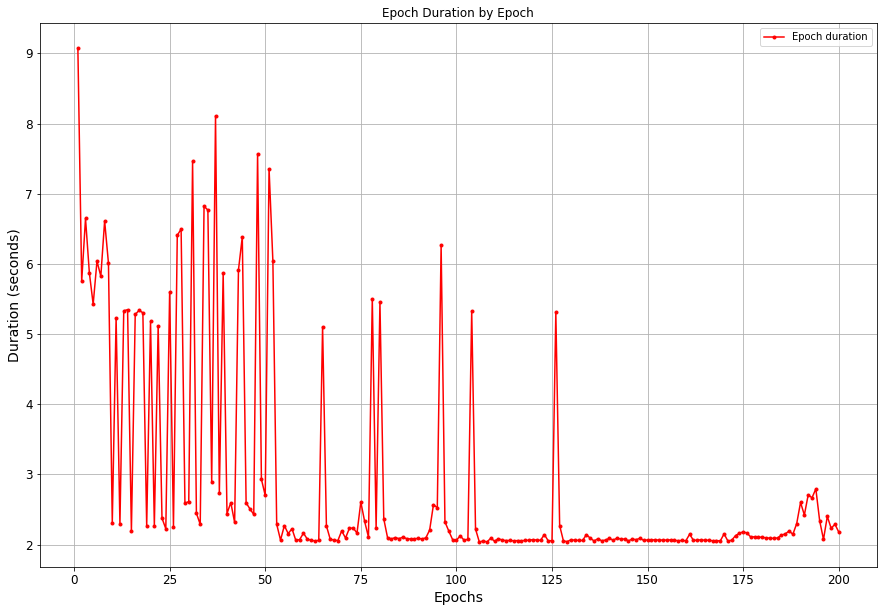

In [23]:
plot_epoch_duration(history)

In [24]:
print('Total time in seconds: %f' % diff_time)

Total time in seconds: 580.611344


In [25]:
model.evaluate(test_ds)

25/25 [==============================] - 0s 9ms/step - loss: 0.8611 - accuracy: 0.7547


[0.8611353039741516, 0.7547059059143066]

In [26]:
# y_pred are probs, we have to convert them to int
y_pred = model.predict(test_ds) 

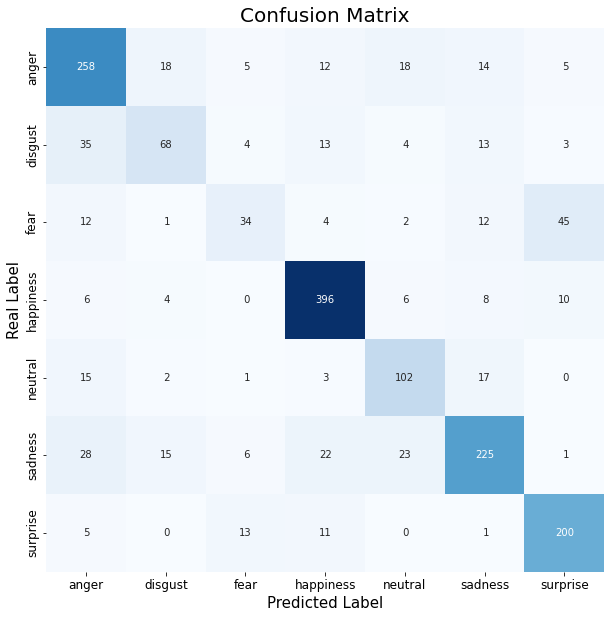

In [27]:
cnf_matrix = plot_confusion_matrix(y_pred, y_test, class_names, return_m=True)

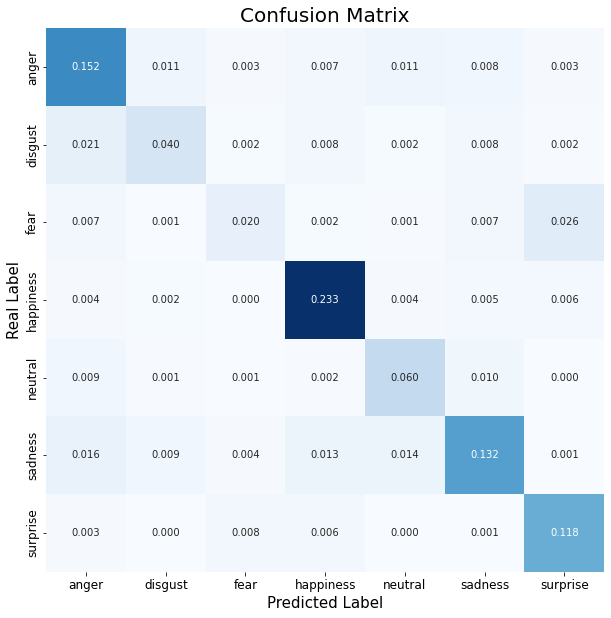

In [28]:
plot_confusion_matrix(y_pred, y_test, class_names, normalize_m='all')

In [29]:
print_confusion_matrix_metrics(cnf_matrix)


False Positives:

	anger -> 101
	disgust -> 40
	fear -> 29
	happiness -> 65
	neutral -> 53
	sadness -> 65
	surprise -> 64

False Negatives:

	anger -> 72
	disgust -> 72
	fear -> 76
	happiness -> 34
	neutral -> 38
	sadness -> 95
	surprise -> 30

True Positives:

	anger -> 258
	disgust -> 68
	fear -> 34
	happiness -> 396
	neutral -> 102
	sadness -> 225
	surprise -> 200

True Negatives:

	anger -> 1269
	disgust -> 1520
	fear -> 1561
	happiness -> 1205
	neutral -> 1507
	sadness -> 1315
	surprise -> 1406

True Positive Rate:

	anger -> 0.782%
	disgust -> 0.486%
	fear -> 0.309%
	happiness -> 0.921%
	neutral -> 0.729%
	sadness -> 0.703%
	surprise -> 0.870%

True Negative Rate:

	anger -> 0.926%
	disgust -> 0.974%
	fear -> 0.982%
	happiness -> 0.949%
	neutral -> 0.966%
	sadness -> 0.953%
	surprise -> 0.956%

Positive Predictive Value:

	anger -> 1
	disgust -> 1
	fear -> 1
	happiness -> 1
	neutral -> 1
	sadness -> 1
	surprise -> 1

Negative Predictive Value:

	anger -> 1
	disgust -> 1
	fear ->

In [30]:
print_general_metrics(y_pred, y_test)


Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.78      0.75       330
           1       0.63      0.49      0.55       140
           2       0.54      0.31      0.39       110
           3       0.86      0.92      0.89       430
           4       0.66      0.73      0.69       140
           5       0.78      0.70      0.74       320
           6       0.76      0.87      0.81       230

    accuracy                           0.75      1700
   macro avg       0.71      0.69      0.69      1700
weighted avg       0.75      0.75      0.75      1700


Accuracy: 0.755

Balanced accuracy: 0.686

F1_Score: 0.746

Precision: 0.746

Recall: 0.755

ROC AUC (OVR): 0.941

ROC AUC (OVO): 0.934




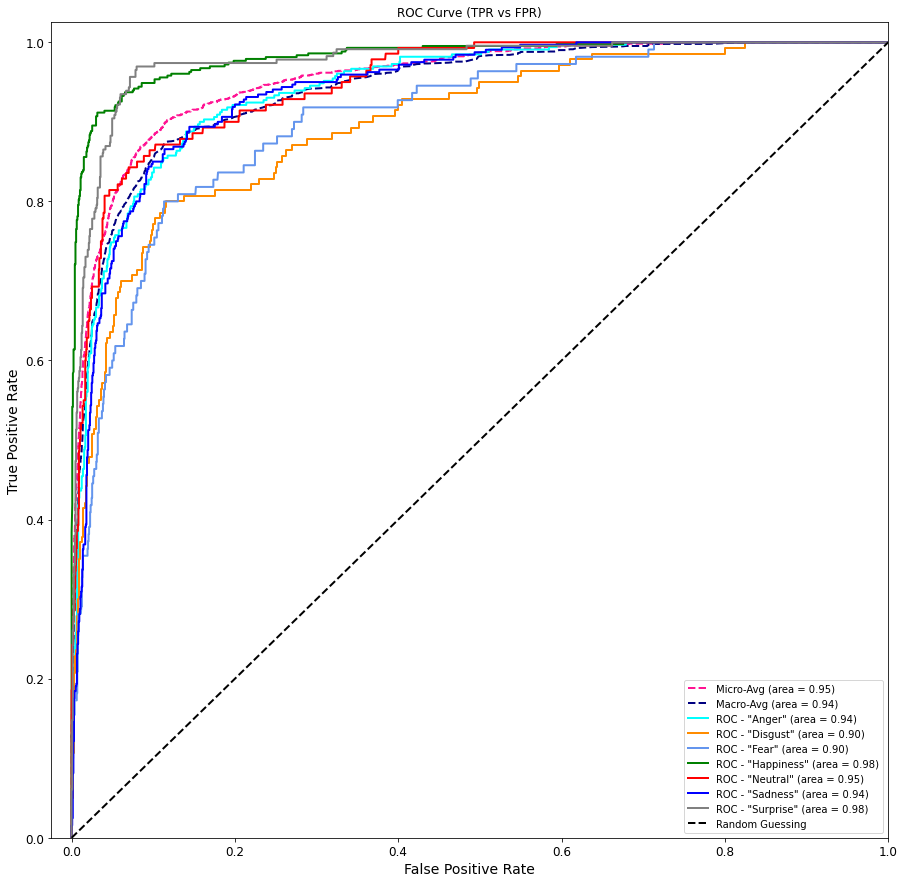

One-vs-One ROC AUC scores:
	0.941459 (macro),
	0.950766 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
	0.941459 (macro),
	0.950766 (weighted by prevalence)


In [31]:
plot_multiclass_roc_curve(y_test, y_pred, class_names)

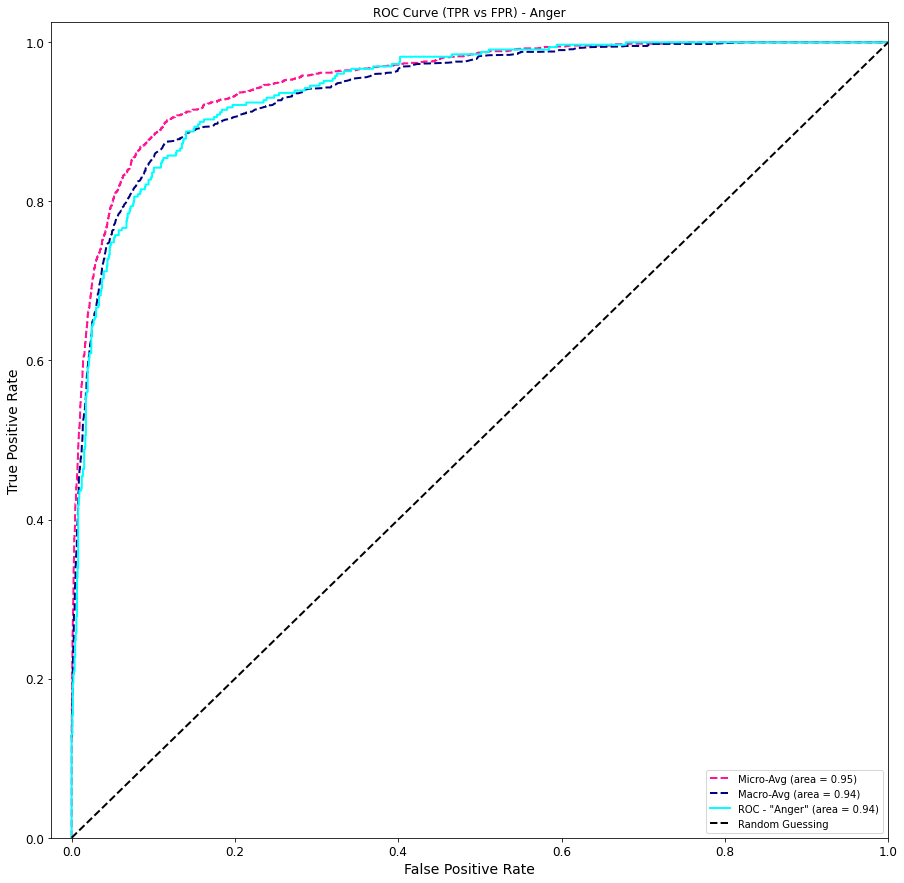

One-vs-One ROC AUC scores:
	0.941459 (macro),
	0.950766 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
	0.941459 (macro),
	0.950766 (weighted by prevalence)


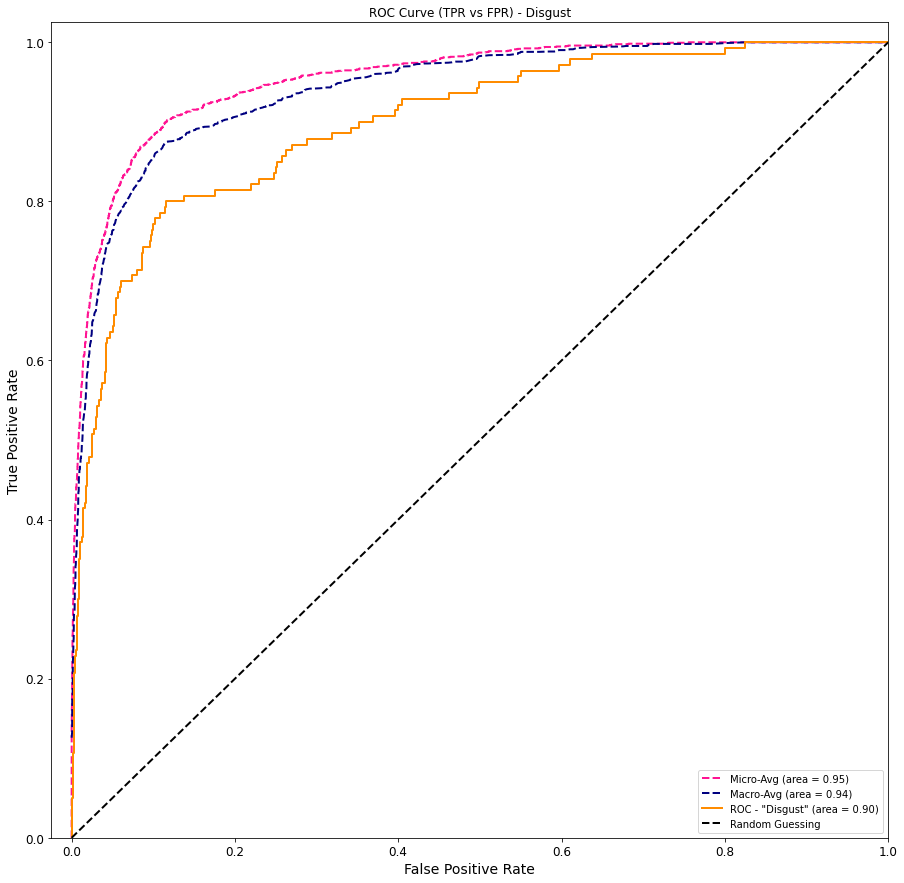

One-vs-One ROC AUC scores:
	0.941459 (macro),
	0.950766 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
	0.941459 (macro),
	0.950766 (weighted by prevalence)


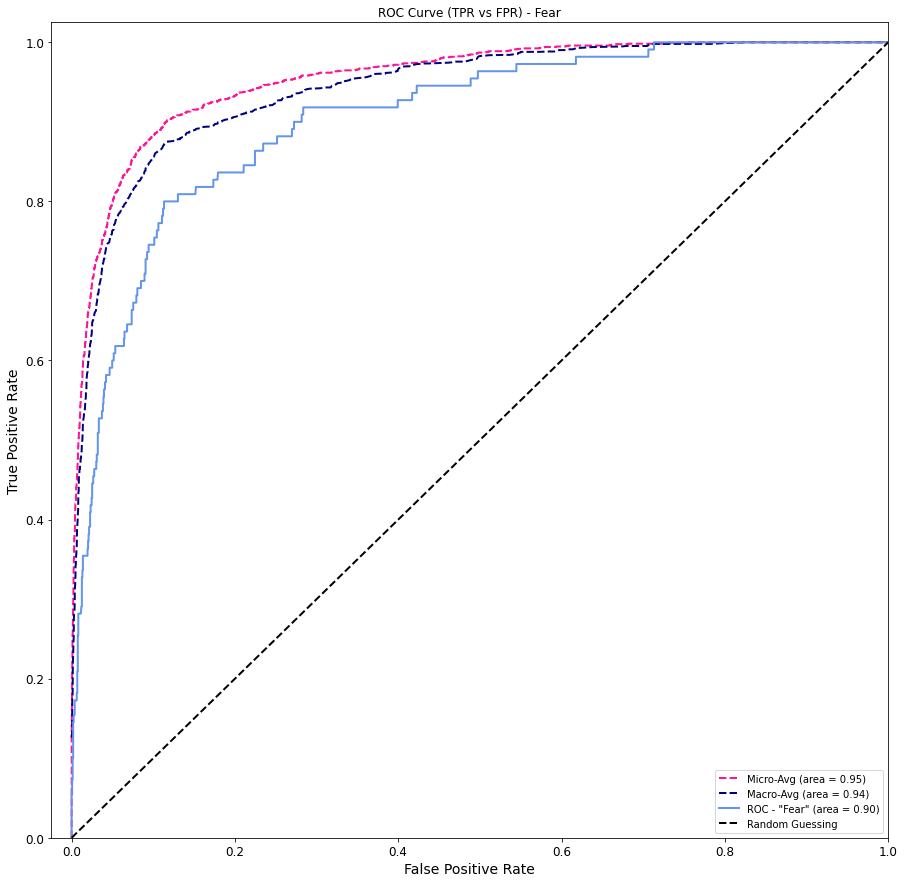

One-vs-One ROC AUC scores:
	0.941459 (macro),
	0.950766 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
	0.941459 (macro),
	0.950766 (weighted by prevalence)


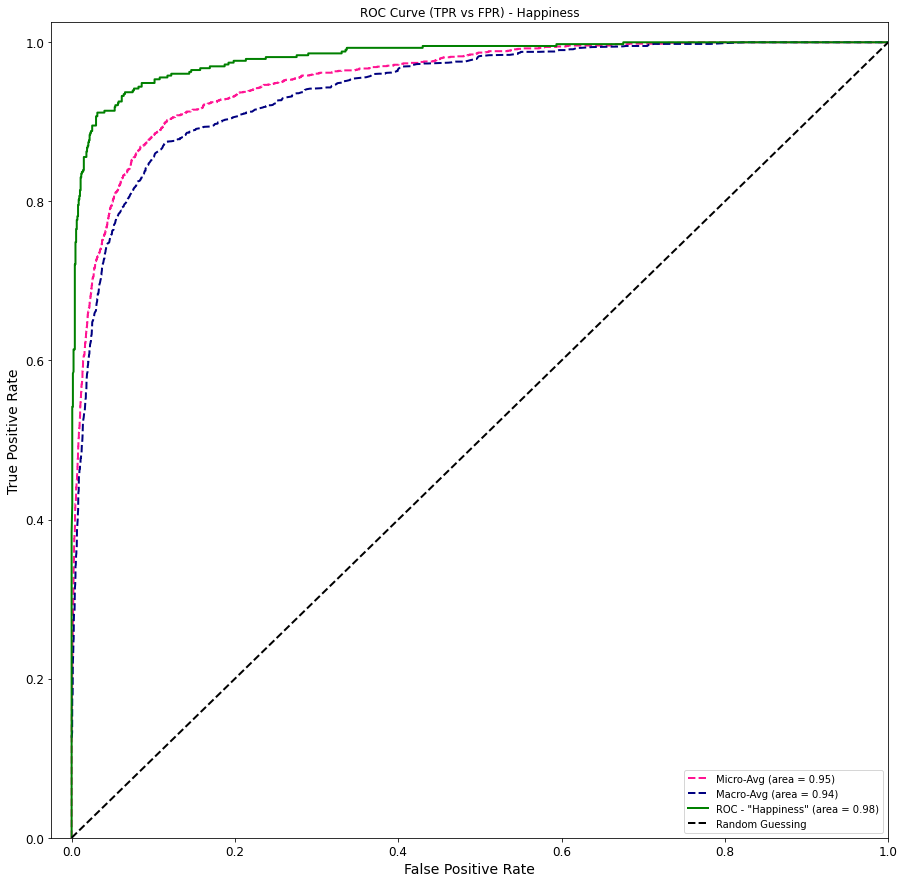

One-vs-One ROC AUC scores:
	0.941459 (macro),
	0.950766 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
	0.941459 (macro),
	0.950766 (weighted by prevalence)


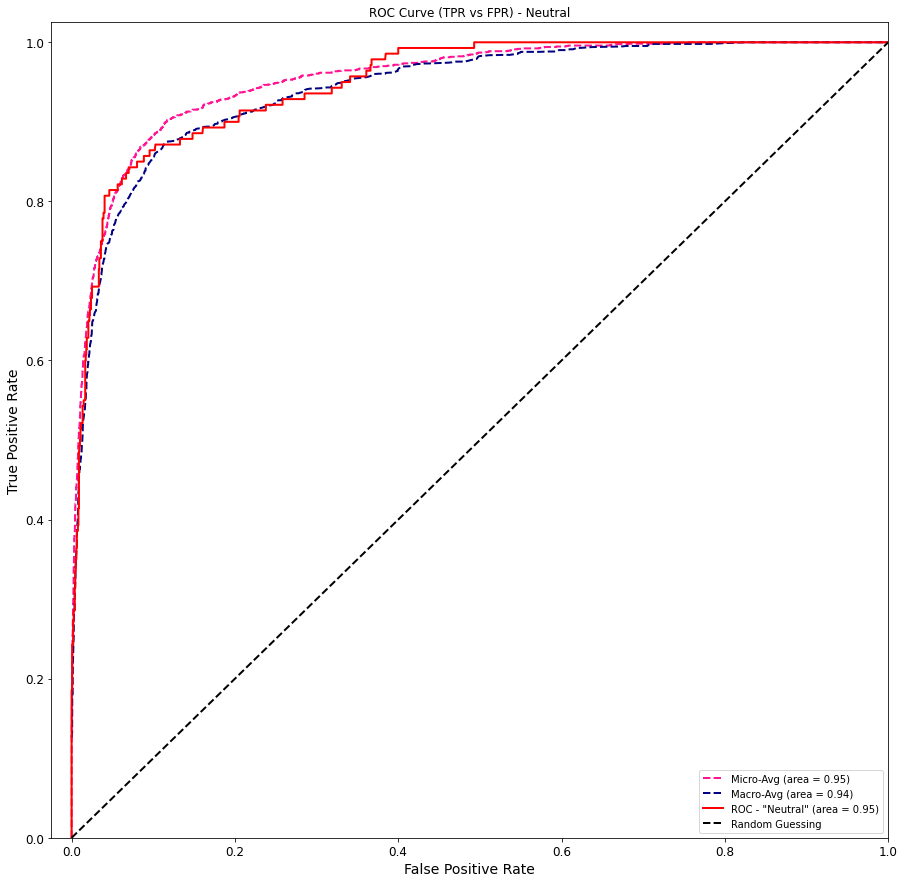

One-vs-One ROC AUC scores:
	0.941459 (macro),
	0.950766 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
	0.941459 (macro),
	0.950766 (weighted by prevalence)


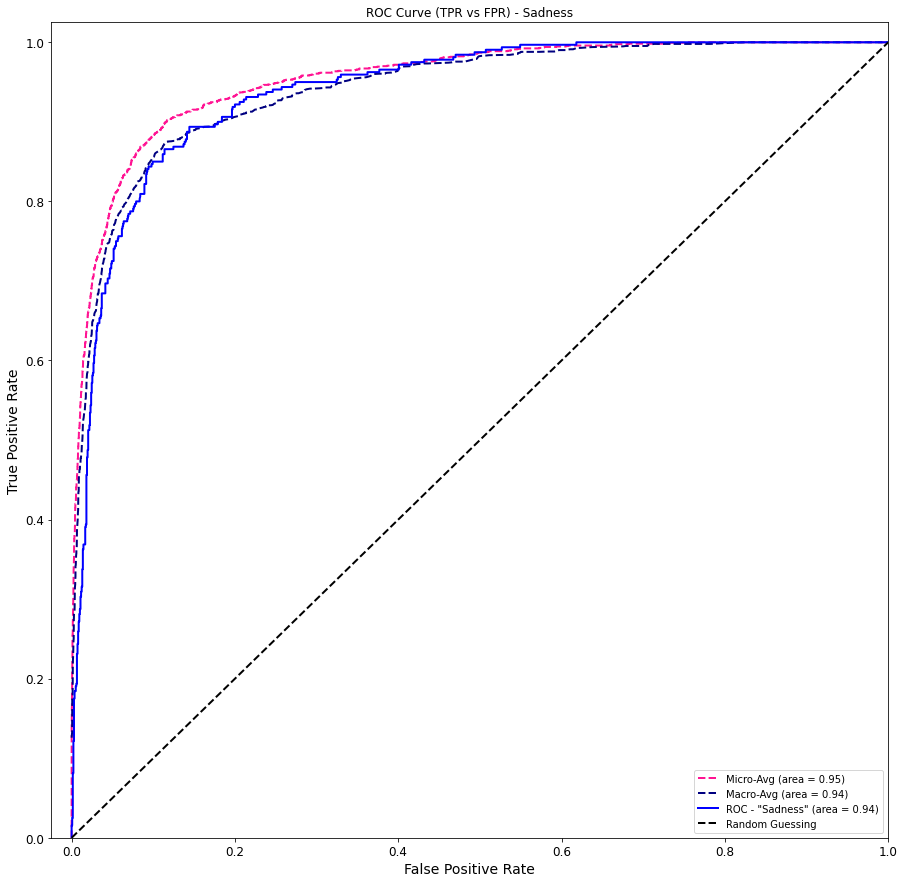

One-vs-One ROC AUC scores:
	0.941459 (macro),
	0.950766 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
	0.941459 (macro),
	0.950766 (weighted by prevalence)


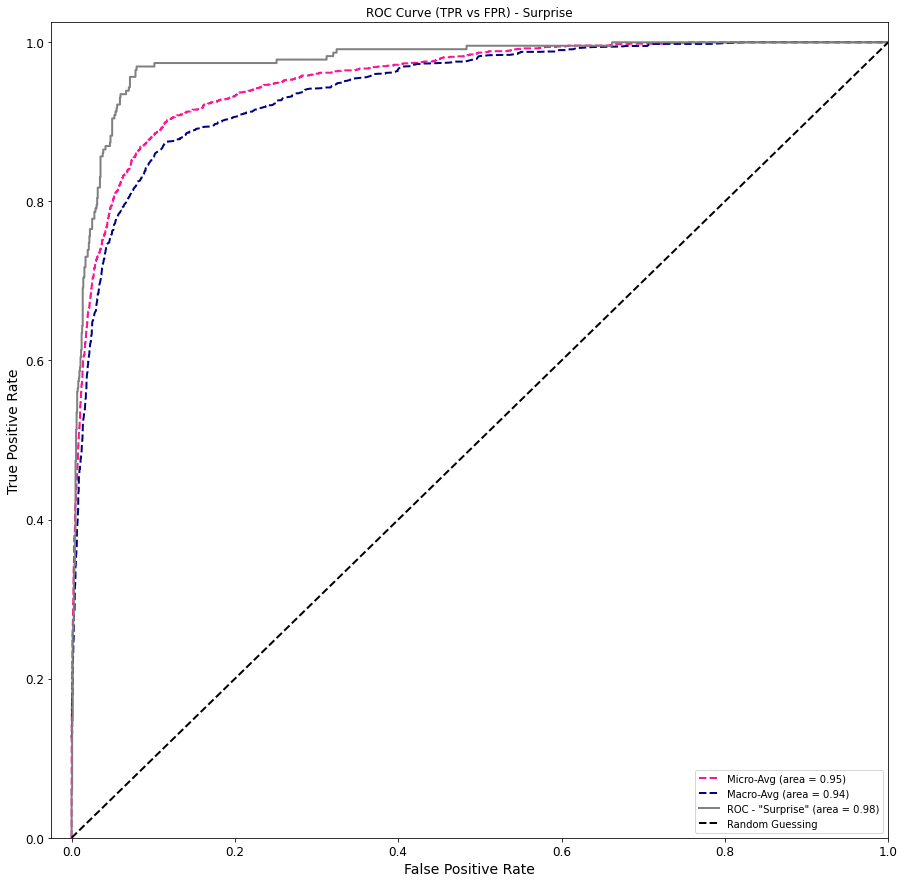

One-vs-One ROC AUC scores:
	0.941459 (macro),
	0.950766 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
	0.941459 (macro),
	0.950766 (weighted by prevalence)


In [32]:
for i, x in enumerate(class_names):
    plot_multiclass_roc_curve(y_test, y_pred, class_names, i, (' - ' + x.capitalize()))

In [33]:
# Lançar extensão TensorBoard
# %load_ext tensorboard

In [34]:
# Iniciar o servidor TensorBoard 
# --port=6006
# --host=127.0.0.1
# %tensorboard --logdir=./tensorboard_logs_CNN_V1_Rafael --host=127.0.0.1

In [76]:
# https://www.analyticsvidhya.com/blog/2020/11/tutorial-how-to-visualize-feature-maps-directly-from-cnn-layers/
# https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c
# https://medium.com/dataseries/visualizing-the-feature-maps-and-filters-by-convolutional-neural-networks-e1462340518e

# https://www.tertiaryinfotech.com/feature-map-visualization-using-tensorflow-keras/

def plot_conv_filter(conv_filter):
    fig, axes = plt.subplots(1, 3, figsize=(5, 5))
    axes = axes.flatten()
    
    for img, ax in zip(conv_filter, axes):
        ax.imshow(img)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
def plot_all_conv_filters(model):
    for layer in model.layers:
        if 'conv' in layer.name:
            filters, bias = layer.get_weights()
            print(layer.name, filters.shape)
            
            # normalize filter values between  0 and 1 for visualization
            f_min, f_max = filters.min(), filters.max()
            filters = (filters - f_min) / (f_max - f_min)  
            
            print(filters.shape[3])
            axis_x = 1
            
            # plotting all the filters
            for i in range(filters.shape[3]):
                # get the filters
                filt = filters[:,:,:, i]
                plot_conv_filter(filt)

conv2d (3, 3, 3, 40)
40


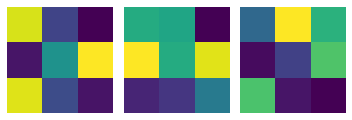

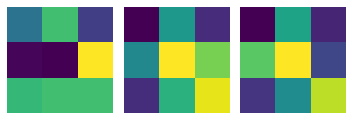

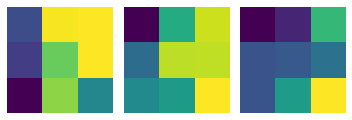

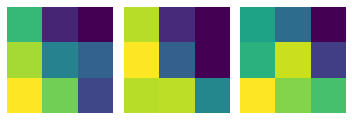

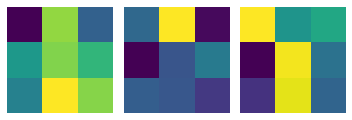

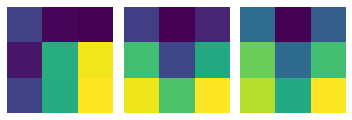

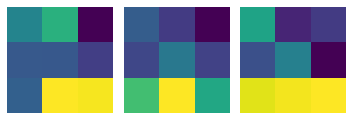

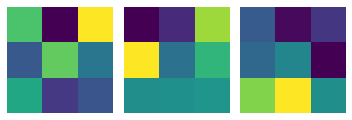

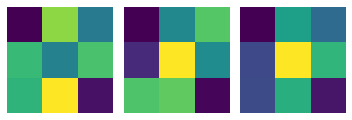

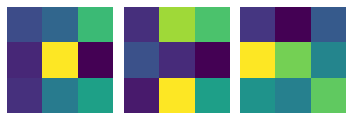

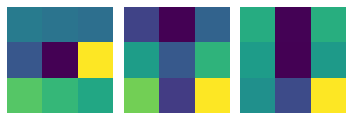

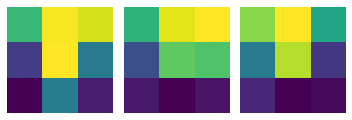

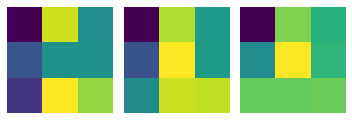

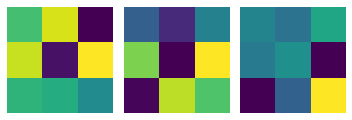

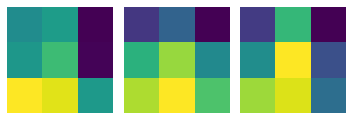

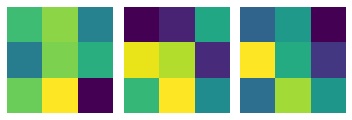

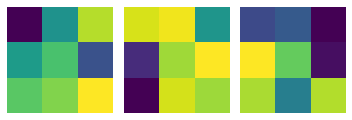

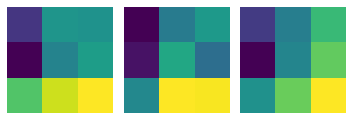

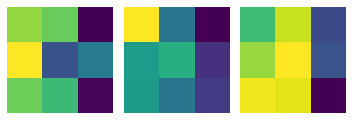

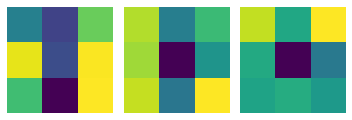

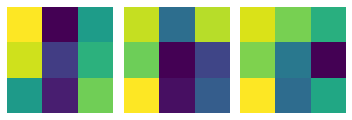

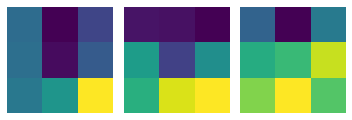

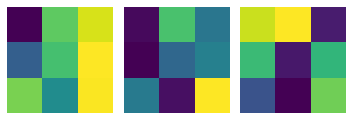

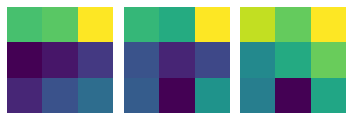

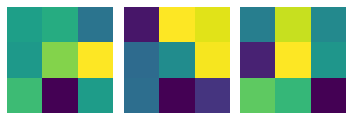

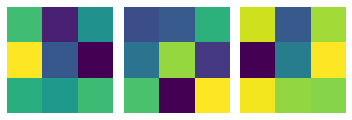

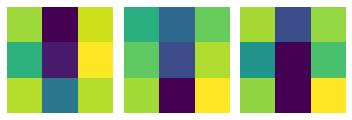

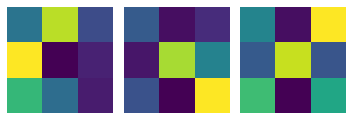

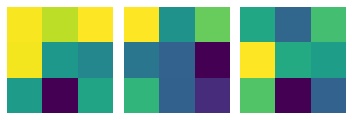

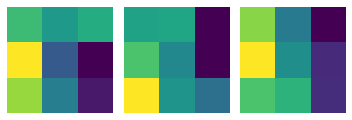

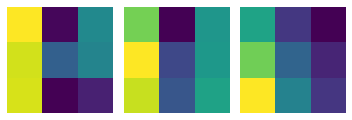

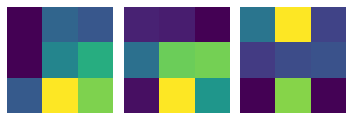

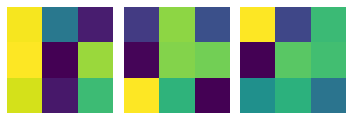

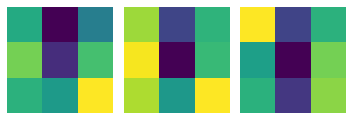

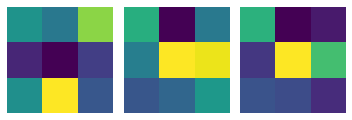

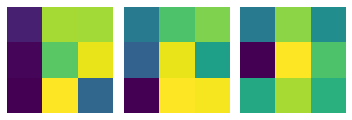

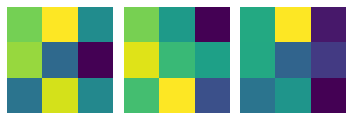

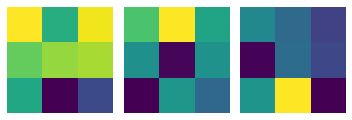

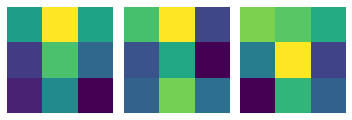

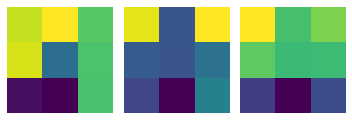

conv2d_1 (3, 3, 40, 70)
70


conv2d_2 (3, 3, 70, 130)
130


conv2d_3 (3, 3, 130, 130)
130


In [78]:
plot_all_conv_filters(model)

In [101]:
def build_visualization_model(model):
    # Let's define a new Model that will take an image as input, and will output
    # intermediate representations for all layers in the previous model after
    # the first.

    # ver se há alguma flag a colocar para o data augmentation nao aparecer
    layer_outputs = [layer.output for i, layer in enumerate(model.layers) if i != 1]

    #visualization_model = Model(img_input, successive_outputs)
    visualization_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
    
    return visualization_model

def tranform_img_to_visualization_model(imagem):
    img = imagem
    img = img.reshape((1,) + img.shape) 

    # Rescale by 1/255
    img /= 255.0
    
    return img


def plot_feature_maps(model, visualization_model, img):
    # Let's run our image through our network, thus obtaining all
    # intermediate representations for this image.
    successive_feature_maps = visualization_model.predict(img)

    # These are the names of the layers, so can have them as part of our plot
    layer_names = [layer.name for layer in model.layers]
    
    # -----------------------------------------------------------------------
    # Now let's display our representations
    # -----------------------------------------------------------------------
    for layer_name, feature_map in zip(layer_names, successive_feature_maps):
        print(f'{layer_name} -> {feature_map.shape}')

        if len(feature_map.shape) == 4:

            #-------------------------------------------
            # Just do this for the conv / maxpool layers, not the fully-connected layers
            #-------------------------------------------
            n_features = feature_map.shape[-1]  # number of features in the feature map
            size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

            # We will tile our images in this matrix
            display_grid = np.zeros((size, size * n_features))

            #-------------------------------------------------
            # Postprocess the feature to be visually palatable
            #-------------------------------------------------
            for i in range(n_features):
                x  = feature_map[0, :, :, i]
                x -= x.mean()
                x /= x.std ()
                x *=  64
                x += 128
                x  = np.clip(x, 0, 255).astype('uint8')
                display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

            #-----------------
            # Display the grid
            #-----------------

            scale = 20. / n_features
            plt.figure( figsize=(scale * n_features, scale) )
            plt.title ( layer_name )
            plt.grid  ( False )
            plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

input_1 -> (1, 80, 80, 3)
sequential -> (1, 80, 80, 40)
conv2d -> (1, 40, 40, 40)
max_pooling2d -> (1, 38, 38, 70)
conv2d_1 -> (1, 19, 19, 70)
max_pooling2d_1 -> (1, 17, 17, 130)
conv2d_2 -> (1, 8, 8, 130)
max_pooling2d_2 -> (1, 6, 6, 130)
conv2d_3 -> (1, 3, 3, 130)
max_pooling2d_3 -> (1, 1170)
flatten -> (1, 70)
dense -> (1, 70)
dropout -> (1, 30)
dense_1 -> (1, 30)
dropout_1 -> (1, 7)


C:\Users\branc\AppData\Local\Temp/ipykernel_9232/2431989562.py:55: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


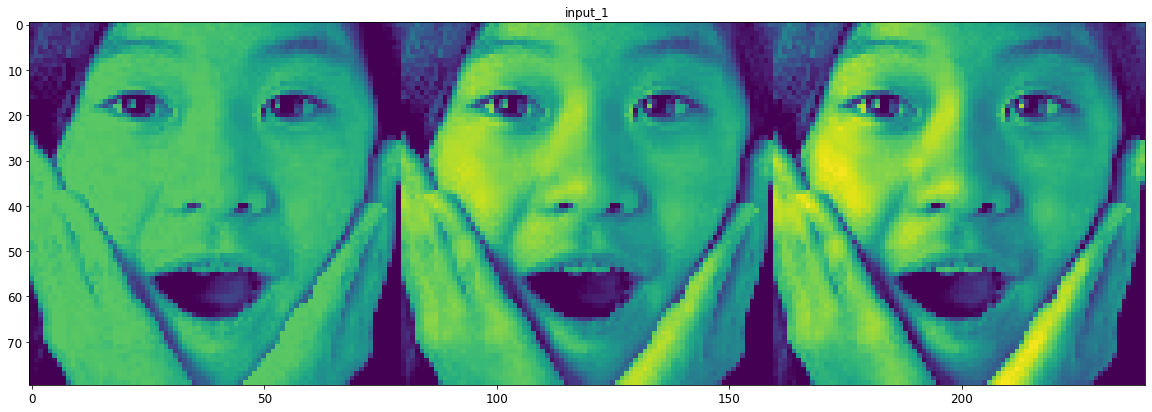

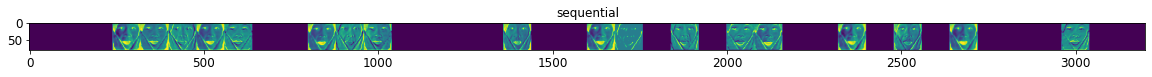

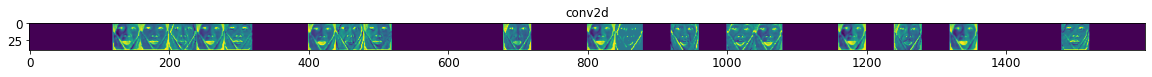

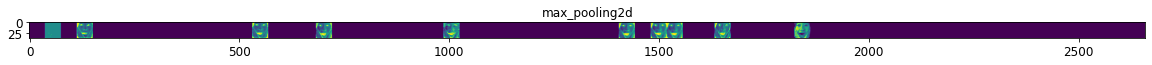

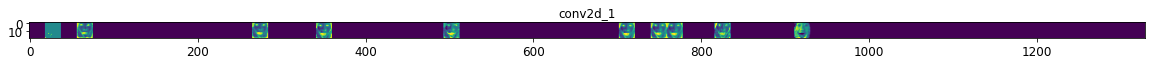

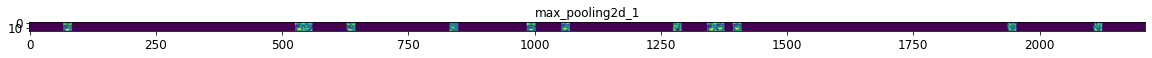

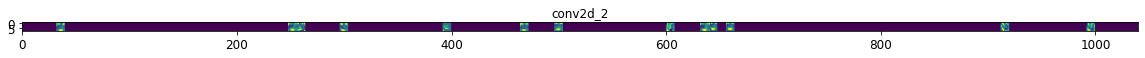

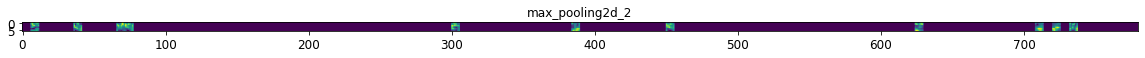

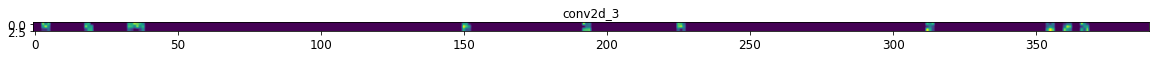

In [103]:
visualization_model = build_visualization_model(model)
img = tranform_img_to_visualization_model(X_test[3])
plot_feature_maps(model, visualization_model, img)

In [ ]:
# testar com imagens nossas
# perceber e analisar resultados no tensorboard (gradientes dos pesos)